In [221]:
import pandas as pd
from load_data import load_data
pd.set_option('display.max_columns', None)
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sn

from scipy.stats import ttest_ind
from scipy.stats import kruskal

In [222]:
price, listings, reviews = load_data()

/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:44: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")


In [223]:
listings.columns

Index(['name', 'last_scraped', 'description', 'neighborhood_overview',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [224]:
amenities = listings["amenities"]

In [225]:
type(amenities[0])

str

Problem: The amenities are not stored in a list for each observation but are a string of a list representation 

In [226]:
amenities = amenities.apply(ast.literal_eval)
type(amenities[0])

list

The elements are now of type list.

Next step: turn them into a list of dummy-variables which indicate wheter an apartment has this particular amenity or not

In [227]:
mlb = MultiLabelBinarizer()
am_array = mlb.fit_transform(amenities)

am_df = pd.DataFrame(am_array, columns = mlb.classes_)
am_df.head()

,2-ring mini hob electric stove,2-ring mini hob. electric stove,"22"" HDTV with Amazon Prime Video, Netflix","22"" TV","24"" TV","27"" TV","28"" HDTV","32"" HDTV","32"" HDTV with Amazon Prime Video, Apple TV, Netflix","32"" HDTV with Amazon Prime Video, Netflix, standard cable","32"" HDTV with Netflix, premium cable","32"" HDTV with Netflix, standard cable","32"" HDTV with standard cable","32"" HDTV with standard cable, Netflix, premium cable","32"" TV","32"" TV with Chromecast","32"" TV with Netflix, standard cable","32"" TV with standard cable, premium cable, Netflix","36"" TV with standard cable","38"" TV with premium cable, Netflix, standard cable","40"" HDTV","40"" HDTV with Amazon Prime Video, Netflix, premium cable, standard cable","40"" HDTV with Amazon Prime Video, premium cable, Netflix","40"" HDTV with Chromecast, standard cable","40"" HDTV with Netflix, premium cable","40"" HDTV with Netflix, standard cable","40"" HDTV with standard cable","40"" TV","42"" HDTV","42"" HDTV with Chromecast, Netflix, standard cable","42"" HDTV with Netflix","42"" HDTV with Netflix, Chromecast","42"" HDTV with Netflix, standard cable","42"" HDTV with Netflix, standard cable, Chromecast, premium cable","42"" TV with Netflix, premium cable","42"" TV with standard cable, Amazon Prime Video, Netflix, premium cable","43"" HDTV with Chromecast, Netflix, standard cable","43"" HDTV with premium cable","43"" HDTV with standard cable","45"" HDTV with Netflix, Amazon Prime Video","48"" HDTV with Netflix, premium cable","49"" HDTV with Amazon Prime Video, Netflix, premium cable, standard cable","50"" HDTV","50"" HDTV with Chromecast, Netflix","50"" HDTV with Netflix","50"" TV with Chromecast","50"" TV with Netflix","50"" TV with premium cable","52"" HDTV with Netflix","55"" HDTV","55"" HDTV with","55"" HDTV with Amazon Prime Video, Netflix","60"" HDTV with Netflix","62"" HDTV with Netflix","65"" HDTV","65"" HDTV with Amazon Prime Video","65"" HDTV with Amazon Prime Video, Chromecast, Netflix","75"" HDTV with Netflix, Amazon Prime Video, Apple TV, Roku",? refrigerator,AEG electric stove,AEG oven,AEG refrigerator,Air conditioning,Alexa Amazon Bluetooth sound system,Aragan oil conditioner,BBQ grill,Baby bath,Baby monitor,Baby safety gates,Babysitter recommendations,Backyard,Baking sheet,Bang & Olufsen sound system with Bluetooth and aux,Barbecue utensils,Basic oven,Basic stove,Bathroom essentials,Bathtub,Beach essentials,Beachfront,Bed linens,Bedroom comforts,Beko electric stove,Beko oven,Bellina electric stove,Belling 4 ring hob stove,Belling stainless steel oven,Belo refrigerator,Bidet,Bikes,Bluetooth sound system,Board games,Boat slip,Boche oven,Body soap,Bora stove,Bosch electric stove,Bosch refrigerator,Bosch stainless steel oven,Bose sound system,Bose Bluetooth sound system,Bread maker,Breakfast,Building staff,Built in wall sound system sound system with aux,Cable TV,Carbon monoxide alarm,Ceiling fan,Central air conditioning,Central heating,Changing table,Children’s books and toys,Children’s books and toys for ages 0-2 years old,Children’s books and toys for ages 0-2 years old and 2-5 years old,"Children’s books and toys for ages 0-2 years old, 2-5 years old, 5-10 years old, and 10+ years old","Children’s books and toys for ages 0-2 years old, 2-5 years old, and 5-10 years old",Children’s books and toys for ages 2-5 years old,Children’s books and toys for ages 2-5 years old and 5-10 years old,Children’s books and toys for ages 5-10 years old and 10+ years old,Children’s dinnerware,Cleaning before checkout,Cleaning products,Clothing storage,Clothing storage: closet,Clothing storage: closet and dresser,Clothing storage: closet and wardrobe,"Clothing storage: closet, dresser, and wardrobe","Clothing storage: closet, wardrobe, and dresser",Clothing storage: dresser,Clothing storage: dresser and closet,Clothing storage: dresser and wardrobe,"Clothing storage: dresser, closet, and wardrobe","Clothing storage: dresser, wardrobe, and closet",Clothing s

We could try to summarize some of them into categories. 
- all HDTVs and TVs into a new variable containing the absolute number of TVs in the apartment
- all children's books and toys to one variable which indicates whether there is children's entertainment or not
- all variables about a dedicated workspace to one variable indicating whether there is a dedicated workspace or not
- all different brands of shampoo, conditioner, stove, ofen, refrigerator, body soap, sound system, coffee machine, 
- all different variables containing information about the fast wifi speed into one
- all free parking/free carport/free garage variables into one which gives the total number of free parking spaces
- all paid parking variables into one which gives the total number of paid parking spaces
- all HDTV variables into one
- all free washer variables into one
- all game console variables into one
- all dryer variables into one
- paid waher into one
- garden or backyard into one
- gym into one

Also we could get rid of some variables which might not have the greatest impact on the price like 
- all different clothing storages
- hangers 
- hot water kattle


Okay lets start with the summaries. Let's write a function which deals with it

In [228]:
def in_one(df, in_cat, out_cat_name, regex = True, sum = False, drop = True):

    if regex == True:
        # get columns to substitute
        col_filter = df.columns.str.contains(in_cat, case = False, regex = True)
        col_names = df.columns[col_filter]

        # create new column
        if sum == True:
            new_var = df.filter(col_names).sum(axis = 1)
        else:
            new_var = df.filter(col_names).sum(axis = 1)
            new_var[new_var>1] = 1
    
    else:
        col_names = in_cat
        if sum == True:
            new_var = df.filter(col_names).sum(axis = 1)
        else:
            new_var = df.filter(col_names).sum(axis = 1)
            new_var[new_var>1] = 1
    df[out_cat_name] = new_var

    if drop == True:
        df = df.drop(col_names, axis = 1)
    
    return df

In [229]:
def add_col(df, sender, receiver, regex = True):
    if regex == True:
        col_filter = df.columns.str.contains(sender, case = False, regex = True)
        sender = df.columns[col_filter] 

    df[receiver] = df.filter(sender).sum(axis=1)+df[receiver]
    df = df.drop(sender, axis = 1)
    return df

In [230]:
def drop_col(df, sender, regex = True):
    if regex == True:
        col_filter = df.columns.str.contains(sender, case = False, regex = True)
        sender = df.columns[col_filter] 
    df = df.drop(sender, axis = 1)
    return df

In [231]:
am_df

,2-ring mini hob electric stove,2-ring mini hob. electric stove,"22"" HDTV with Amazon Prime Video, Netflix","22"" TV","24"" TV","27"" TV","28"" HDTV","32"" HDTV","32"" HDTV with Amazon Prime Video, Apple TV, Netflix","32"" HDTV with Amazon Prime Video, Netflix, standard cable","32"" HDTV with Netflix, premium cable","32"" HDTV with Netflix, standard cable","32"" HDTV with standard cable","32"" HDTV with standard cable, Netflix, premium cable","32"" TV","32"" TV with Chromecast","32"" TV with Netflix, standard cable","32"" TV with standard cable, premium cable, Netflix","36"" TV with standard cable","38"" TV with premium cable, Netflix, standard cable","40"" HDTV","40"" HDTV with Amazon Prime Video, Netflix, premium cable, standard cable","40"" HDTV with Amazon Prime Video, premium cable, Netflix","40"" HDTV with Chromecast, standard cable","40"" HDTV with Netflix, premium cable","40"" HDTV with Netflix, standard cable","40"" HDTV with standard cable","40"" TV","42"" HDTV","42"" HDTV with Chromecast, Netflix, standard cable","42"" HDTV with Netflix","42"" HDTV with Netflix, Chromecast","42"" HDTV with Netflix, standard cable","42"" HDTV with Netflix, standard cable, Chromecast, premium cable","42"" TV with Netflix, premium cable","42"" TV with standard cable, Amazon Prime Video, Netflix, premium cable","43"" HDTV with Chromecast, Netflix, standard cable","43"" HDTV with premium cable","43"" HDTV with standard cable","45"" HDTV with Netflix, Amazon Prime Video","48"" HDTV with Netflix, premium cable","49"" HDTV with Amazon Prime Video, Netflix, premium cable, standard cable","50"" HDTV","50"" HDTV with Chromecast, Netflix","50"" HDTV with Netflix","50"" TV with Chromecast","50"" TV with Netflix","50"" TV with premium cable","52"" HDTV with Netflix","55"" HDTV","55"" HDTV with","55"" HDTV with Amazon Prime Video, Netflix","60"" HDTV with Netflix","62"" HDTV with Netflix","65"" HDTV","65"" HDTV with Amazon Prime Video","65"" HDTV with Amazon Prime Video, Chromecast, Netflix","75"" HDTV with Netflix, Amazon Prime Video, Apple TV, Roku",? refrigerator,AEG electric stove,AEG oven,AEG refrigerator,Air conditioning,Alexa Amazon Bluetooth sound system,Aragan oil conditioner,BBQ grill,Baby bath,Baby monitor,Baby safety gates,Babysitter recommendations,Backyard,Baking sheet,Bang & Olufsen sound system with Bluetooth and aux,Barbecue utensils,Basic oven,Basic stove,Bathroom essentials,Bathtub,Beach essentials,Beachfront,Bed linens,Bedroom comforts,Beko electric stove,Beko oven,Bellina electric stove,Belling 4 ring hob stove,Belling stainless steel oven,Belo refrigerator,Bidet,Bikes,Bluetooth sound system,Board games,Boat slip,Boche oven,Body soap,Bora stove,Bosch electric stove,Bosch refrigerator,Bosch stainless steel oven,Bose sound system,Bose Bluetooth sound system,Bread maker,Breakfast,Building staff,Built in wall sound system sound system with aux,Cable TV,Carbon monoxide alarm,Ceiling fan,Central air conditioning,Central heating,Changing table,Children’s books and toys,Children’s books and toys for ages 0-2 years old,Children’s books and toys for ages 0-2 years old and 2-5 years old,"Children’s books and toys for ages 0-2 years old, 2-5 years old, 5-10 years old, and 10+ years old","Children’s books and toys for ages 0-2 years old, 2-5 years old, and 5-10 years old",Children’s books and toys for ages 2-5 years old,Children’s books and toys for ages 2-5 years old and 5-10 years old,Children’s books and toys for ages 5-10 years old and 10+ years old,Children’s dinnerware,Cleaning before checkout,Cleaning products,Clothing storage,Clothing storage: closet,Clothing storage: closet and dresser,Clothing storage: closet and wardrobe,"Clothing storage: closet, dresser, and wardrobe","Clothing storage: closet, wardrobe, and dresser",Clothing storage: dresser,Clothing storage: dresser and closet,Clothing storage: dresser and wardrobe,"Clothing storage: dresser, closet, and wardrobe","Clothing storage: dresser, wardrobe, and closet",Clothing s

In [232]:
# first drop stuff we don't need anymore (too standard, too broad, too specific)
am_df = drop_col(am_df, "(Clothing storage)")
am_df = drop_col(am_df, ["Bedroom comforts", "Bread maker","Carbon monoxide alarm",
"Children’s dinnerware", "Drying rack for clothing", "Fireplace guards", "Fire extinguisher", 
"Hot water kettle", "Hangers", "Iron", "Keypad", "Pocket wifi", "Mini fridge",
"Mosquito net", "Outlet covers", "Pour-over coffee", "Portable fans",
"Portable heater", "Portable air conditioning", "Radiant heating", "Record player", 
"Rice maker", "Shower gel", "Ski-in/Ski-out", "Table corner guards", "Trash compactor",
"Wine glasses", "Window guards", "Baking sheet", "Barbecue utensils", "Boat slip",
"Cable TV","Changing table","Cleaning products","EV charger","Ethernet connection", 
"Extra pillows and blankets", "First aid kit","Laundromat nearby", "Room-darkening shades",
"Smart lock", "Smoke alarm", "Toaster", "Microwave", "Essentials", "Bathroom essentials", "Fire pit", 
"Lock on bedroom door", "Hot water", "Beach essentials", "Board games", "Building staff", 
"Cooking basics", "Dining table", "Dishes and silverware", "Host greets you", "Luggage dropoff allowed", 
"Self check-in"], regex = False)

# sum up all luxury or extraordinary equipment
am_df = in_one(am_df, ["Piano", "Ping pong table", "Kayak", "BBQ grill", "Bidet", "Bikes"], "Special_stuff", regex = False, sum = True, drop = True)

# sum true
am_df = in_one(am_df, "(HDTV)|(^\d\d..TV)|(^TV)", "TV_number", regex = True, sum = True, drop = True)
am_df = in_one(am_df, "(game console)", "Oven_number", regex = True, sum = True, drop = True)
am_df = in_one(am_df, "(^outdoor)", "Outdoor_stuff_number", regex = True, sum = True, drop = True)
am_df = in_one(am_df, "(^Baby)|(^Crib$)|( crib$)|(^High chair$)", "Baby_friendly", regex = True, sum = True, drop = True)


# sum false
am_df = in_one(am_df, "(body soap)", "Body_soap_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(.oven)|(^oven)", "Oven_available", regex = True, sum = True, drop = True)
am_df = in_one(am_df, "(garden or backyard)|(^backyard)|(^garden)", "Garden_backyard_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^free.*parking)|(^free.*garage)|(^free.*carport)", "Free_parking_number", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^paid.*parking)|(^paid.*garage)|(^paid.*carport)", "Paid_parking_number", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(.stove)|(^stove)", "Stoves_number", regex = True, sum = True, drop = True)
am_df = in_one(am_df, "(refrigerator.)|(refrigerator)|(^Freezer$)", "Refridgerator_number", regex = True, sum = True, drop = True)
am_df = in_one(am_df, "(sound system)", "sound_system_number", regex = True, sum = True, drop = True)
am_df = in_one(am_df, "(^Children’s books and toys)", "Children_Entertainment", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Dedicated workspace)", "Workspace", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(conditioner)|(shampoo)", "Shampoo_Conditioner_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Fast wifi.)", "Fast_wifi_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Gym)|(. gym)", "Gym_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(coffee machine)|(Nespresso)|(^Coffee maker)", "Coffee_machine_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Dryer)|(Paid dryer)|(^Free dryer)", "Dryer_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Washer)|(Paid washer)|(Free washer)", "Washer_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Hot tub)|(.hot tub)", "Hot_tub_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Pool)|(shared.*pool)|(private.*pool)", "Pool_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(patio or balcony)", "Patio_balcony_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(sauna)", "Sauna_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Wifi)", "Wifi_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(air conditioning)", "AC_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(heating)", "heating_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Kitchen$)|(^Full kitchen$)", "kitchen_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Lockbox$)|(^Safe$)", "Safe_available", regex = True, sum = False, drop = True)
am_df = in_one(am_df, "(^Waterfront$)|(^Beachfront$)|(^Lake access$)", "Water_location", regex = True, sum = False, drop = True)




/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_80544/700297093.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  col_filter = df.columns.str.contains(sender, case = False, regex = True)
/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_80544/2520369971.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  col_filter = df.columns.str.contains(in_cat, case = False, regex = True)


In [233]:
am_df.head()


,Bathtub,Bed linens,Breakfast,Ceiling fan,Cleaning before checkout,Dishwasher,Elevator,Hair dryer,Indoor fireplace,Long term stays allowed,Pets allowed,Private entrance,Security cameras on property,Single level home,Suitable for events,Special_stuff,TV_number,Outdoor_stuff_number,Baby_friendly,Body_soap_available,Oven_available,Garden_backyard_available,Free_parking_number,Paid_parking_number,Stoves_number,Refridgerator_number,sound_system_number,Children_Entertainment,Workspace,Shampoo_Conditioner_available,Fast_wifi_available,Gym_available,Coffee_machine_available,Dryer_available,Washer_available,Hot_tub_available,Pool_available,Patio_balcony_available,Sauna_available,Wifi_available,AC_available,heating_available,kitchen_available,Safe_available,Water_location
0,1,1,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0,2,0,1,1,1,1,0,0,2,0,0,1,1,0,0,1,1,1,0,0,1,0,1,1,1,0,0,0
1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0
2,0,1,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,1,1,1,0,0,1,0,1,0,1,1,0,0
3,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0
4,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,4,1,1,0,1,0,1,2,1,0,1,1,0,1,1,1,1,0,0,0,0,1,0,1,1,1,0


In [234]:
len(pd.unique(am_df.columns))

45

We still have more than 50 different amenities.
Let's have a look how man of these are observed frequently

In [235]:
summary = am_df[am_df !=0].sum(axis = 0).sort_values(ascending = False)
summary.where(summary <=20).dropna()

Fast_wifi_available    11.0
Sauna_available         8.0
Ceiling fan             7.0
Suitable for events     1.0
Pets allowed            1.0
dtype: float64

 The amenities seem to be less relevant, moreover it seems strange that only 1 listing allows pets and only 1 is suitable for events. Also fast wifi might be something that is quite subjective. A ceiling fan might not be the most important feature of an apartment in Dublin. A sauna however is quite luxurious. Lets add it to our special_stuff variable

In [236]:
am_df["Special_stuff"] = am_df["Special_stuff"] + am_df["Sauna_available"]
drop_am = list(summary.where(summary <=15).dropna().index)
am_df = drop_col(am_df, drop_am, regex = False)


In [237]:
am_df.describe()

,Bathtub,Bed linens,Breakfast,Cleaning before checkout,Dishwasher,Elevator,Hair dryer,Indoor fireplace,Long term stays allowed,Private entrance,Security cameras on property,Single level home,Special_stuff,TV_number,Outdoor_stuff_number,Baby_friendly,Body_soap_available,Oven_available,Garden_backyard_available,Free_parking_number,Paid_parking_number,Stoves_number,Refridgerator_number,sound_system_number,Children_Entertainment,Workspace,Shampoo_Conditioner_available,Gym_available,Coffee_machine_available,Dryer_available,Washer_available,Hot_tub_available,Pool_available,Patio_balcony_available,Wifi_available,AC_available,heating_available,kitchen_available,Safe_available,Water_location
count,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000,6922.000000
mean,0.101271,0.369402,0.184484,0.021237,0.223490,0.234325,0.670904,0.224213,0.726813,0.259896,0.065444,0.060965,0.059376,0.621208,0.070789,0.227535,0.055042,0.367235,0.194597,0.526293,0.138399,0.279399,0.463883,0.010691,0.050852,0.571078,0.679428,0.039728,0.238081,0.476741,0.756718,0.028460,0.004190,0.180006,0.934268,0.039006,0.930945,0.852499,0.146201,0.026871
std,0.301709,0.482678,0.387907,0.144183,0.416614,0.423607,0.469919,0.417093,0.445628,0.438609,0.247325,0.239283,0.264063,0.485121,0.335991,0.768983,0.228078,0.510614,0.395919,0.499344,0.345344,0.448736,0.599748,0.102848,0.219712,0.494958,0.466730,0.195335,0.425940,0.499495,0.429095,0.166295,0.064596,0.384220,0.247832,0.193623,0.253566,0.354630,0.353333,0.161718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,2.000000,7.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Variable Selection
In order to find the most important amenities for our model we will train several random forests and compare their accurancy/cross entropy loss when leaving out one of the amenities

In [259]:
# train full random forest
forest = RandomForestRegressor(100, random_state = 123, max_features = "sqrt", max_depth = 1)
X_train, X_test, y_train, y_test = train_test_split(am_df, price, random_state = 123)

In [262]:
from sklearn import kernel_ridge
KR = kernel_ridge.KernelRidge(kernel = "rbf")
KR.fit(X_train, y_train)
KR.score(X_test,y_test)

Train the forest with the training data

In [279]:
forest.fit(X_train, y_train,)

RandomForestRegressor(max_depth=1, max_features='sqrt', random_state=123)

In [280]:
forest.score(X_test, y_test)

-2.1618726408685562

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [281]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=am_df.columns)


Now we can plot this contribution

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_80544/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


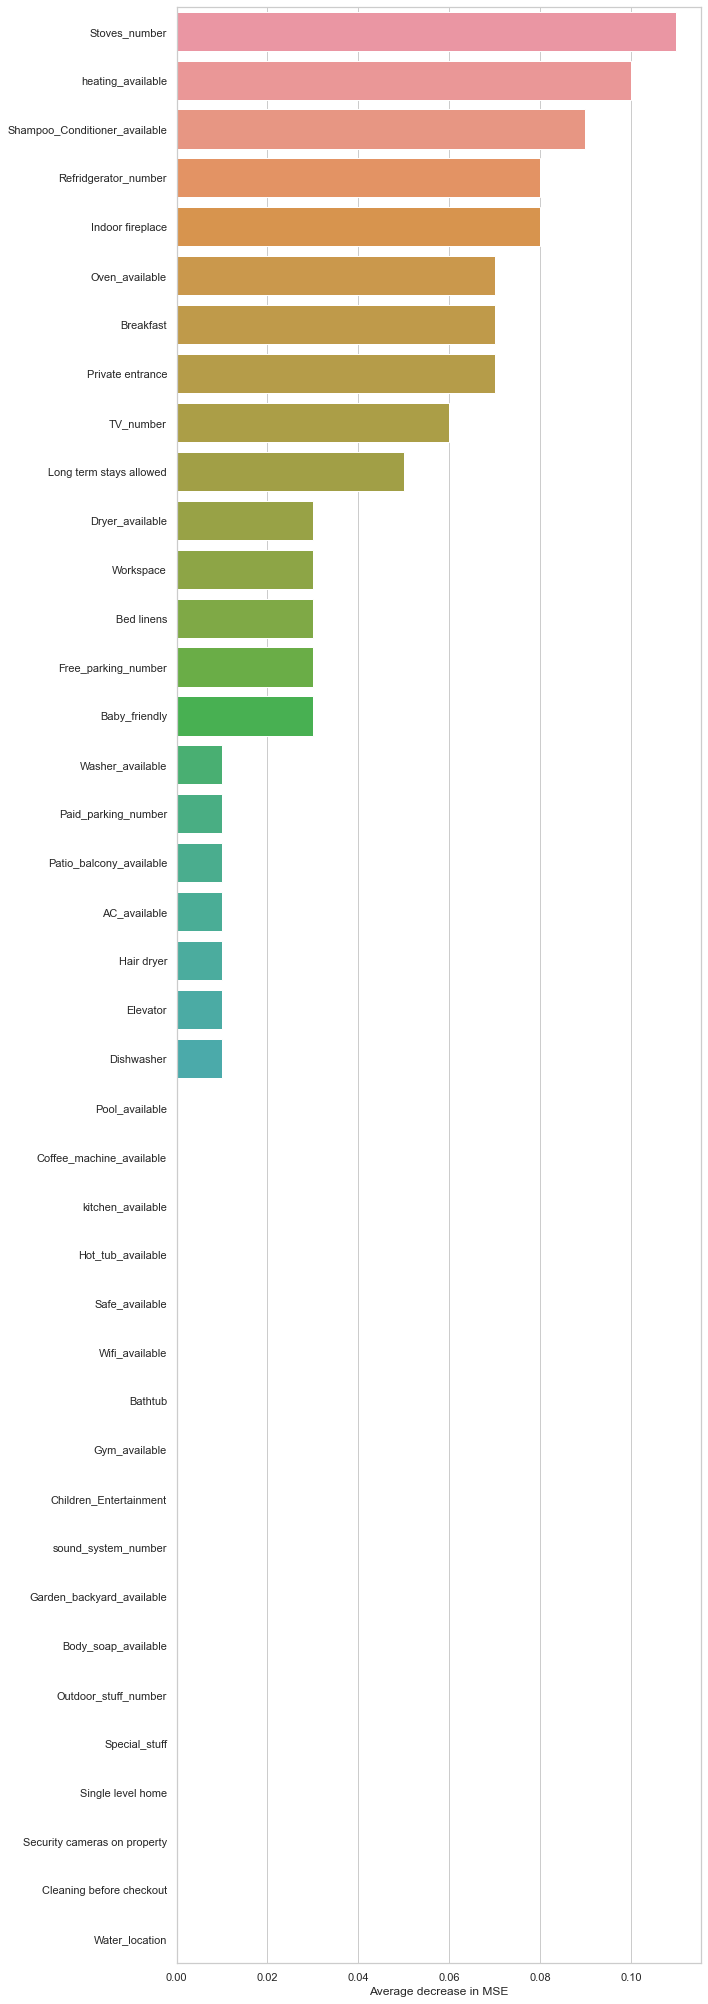

In [282]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

The blue bars of the diagram indicate by how much the impurity was decreased on average when using the feature in a tree. The black lines give the standard deviation

Problem of the importance measure: We only consider the training data and how important each feature is on average for the training model. 

Therefore we also use another approach. We take the test data and shuffle a feature randomly and evaluate the mode score. Thereby we cut the connection between target and feature. If the model accuracy/MSE decreases significantly the feature might be important for the prediction.

## Permutation approach

In [283]:
result = permutation_importance(forest, X_test, y_test, n_repeats=50, random_state=42)

forest_importances = pd.Series(result.importances_mean, index=am_df.columns)


/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_80544/1823862734.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


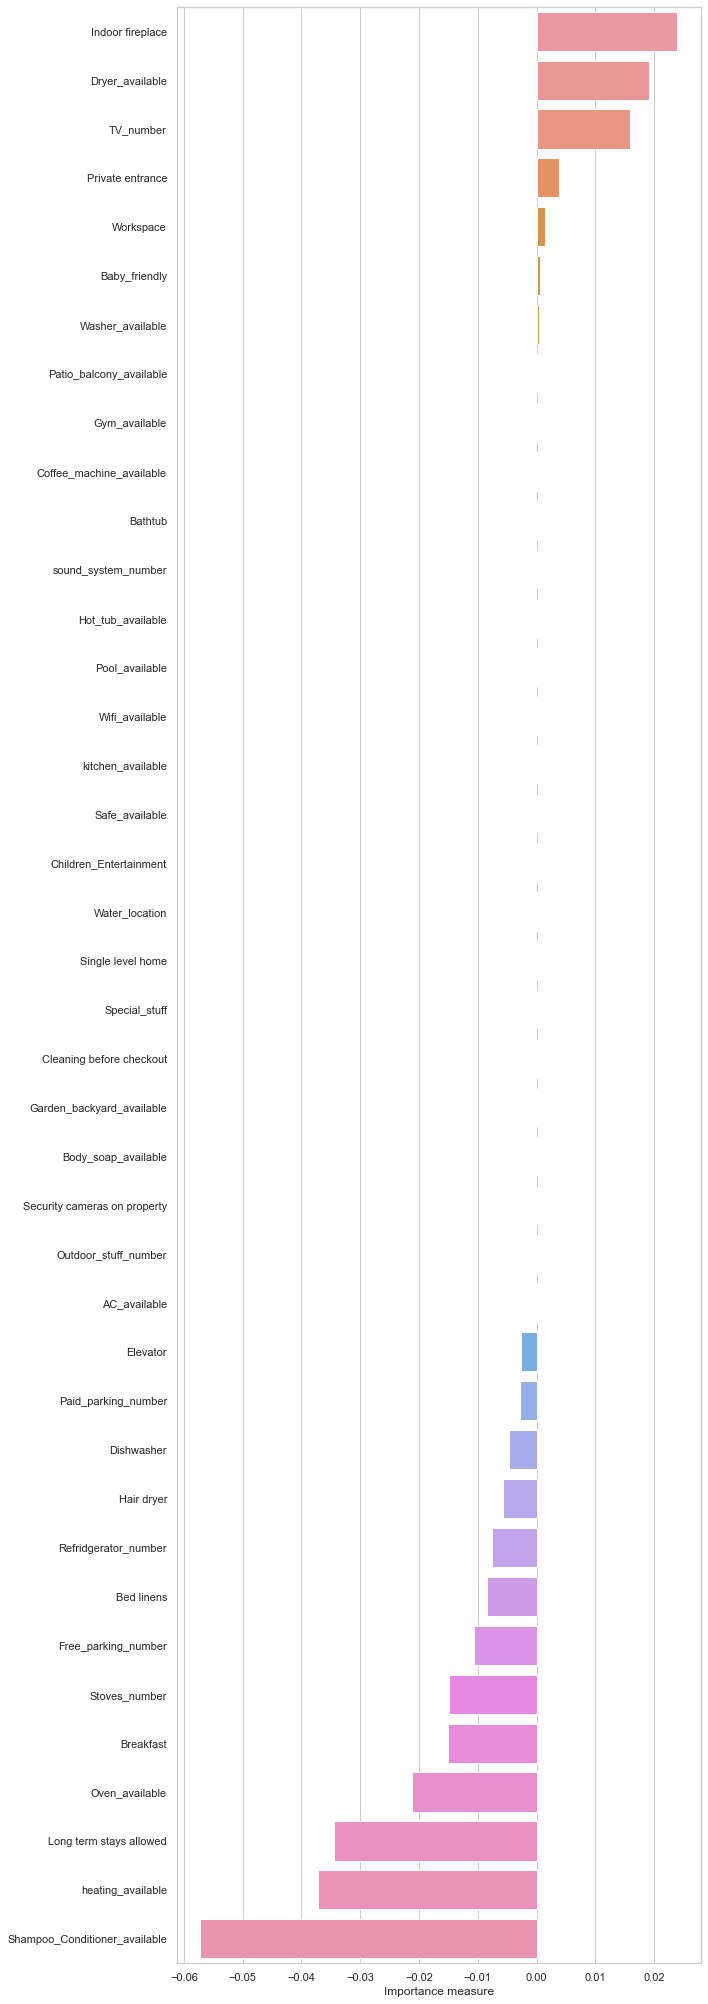

In [284]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

We observe that indoor fireplace, smoke alarm, heating, dryer, Iron are not as important as indicate by the first approach. The problem of this method is that the importance of highly correlated amenities disappears as shuffling the first feature the model could still get the information by the second correlated feature. 
This can be the case for our data. For instance the possibility to stay for a longer time might be highly correlated with the availability of a washing machine or kitchen and an oven.

# Correlation approach
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

# Final variable choice

Essentials, long_term_stays, Breakfast, Washer, Kitchen, Hangers, Hottub

In [262]:
final_am = ["Essentials", "Long term stays allowed", "Breakfast", "Washer", "Kitchen", "Hangers", "Hot tub"]
final = am_df[final_am]
final.to_csv("amenities.csv")

In [263]:
final

,Essentials,Long term stays allowed,Breakfast,Washer,Kitchen,Hangers,Hot tub
0,1,1,1,0,0,1,0
1,1,0,1,1,1,1,0
2,1,0,1,1,1,1,0
3,1,0,1,0,0,1,0
4,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...
6971,1,1,0,1,1,1,0
6972,0,1,0,1,1,0,1
6973,1,1,0,1,1,1,0
6974,1,1,0,1,1,1,0
